# 9.530 Final Project: Hopfield Short-Term Memory Recall

Hopfield networks are compelling solutions to the biological memory question, which asks for an efficient mechanism for retrieving a stored prototype vector, or "memory", from a noisy input. A natural question that arises is whether Hopfield networks are still fit to serve as the backdrop for other emergent memory recall phenomena. In particular, can the **short-term memory behaviors** of storing and quickly misremembering new information, such as forgetting someone's name after meeting them, or deja vu for a word you've never seen before, emerge from Hopfield networks? We propose a performant algorithm for short-term memory retrieval in Hopfield networks. Our algorithm for short-term memory retrieval performs at a **70% accuracy** on our visual recall task, which rivals the **76% accuracy that human players have averaged** on the same task.

This project explores the following:

- A **candidate algorithm for short-term storing and recall mechanisms** in Hopfield networks.
- A **visual memory task**, where participants are asked to mark whether or not they've seen black-and-white pixel images, and analysis of empirical data collected.
- An empirical exploration of the number of prototypes stored by a Hopfield network and the probability of the network converging to a prototype state.

# Motivation

Hopfield Networks describe an underlying structure that lends itself to many interesting emergent behaviors in memory recall. I'm curious about whether or not this same underlying structure can replicate short-term memory behaviors we've found in humans. Namely, replicating a similar **performance accuracy on a visual memory task** as humans.

# Hopfield Network Implementation

We implement a short-term recall algorithm in a discrete Hopfield Network with an asynchronous update rule. We begin with a vanilla Hopfield Network.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [90]:
## helper function for hamming dist
def hamming(result, input):
  h = np.sum(np.abs(result - input) / 2)
  if h == 25: # returns a flipped state
    return 0
  else:
    return h

def check_convergence(target, prototypes):
  hamming = np.sum(np.abs(target - prototypes) / 2, axis=1)
  if np.max(hamming) == 25:
    # spurious pattern is just flipped prototype
    return np.max(hamming), np.argmax(hamming)
  return np.min(hamming), np.argmin(hamming)

In [166]:
class Hopfield:
  def __init__(self, num_nodes, max_iter):
    self.num_nodes = num_nodes
    self.weights = np.zeros((num_nodes, num_nodes))
    self.max_iter = max_iter

  def short_term_recall(self, inputs, c=1):
    return

  def fill_prototypes(self, prototypes):
    """
    Train weights on prototypes.
    The weights of a prototype are set to
    """
    self.prototypes = prototypes
    n = len(prototypes)

    # hebbian correlation
    for i in range(n):
      t = prototypes[i]
      self.weights += np.outer(t, t)

    # zero out diagonal
    np.fill_diagonal(self.weights, 0)
    self.weights /= self.num_nodes


  def recall(self, state, threshold=None):
    """
    Predict prototype that state is closest to.

    threshold: a np.array of size self.num_nodes
    """
    if not threshold:
      self.threshold = np.zeros(self.num_nodes)
    else:
      self.threshold = threshold
    e = self.energy(state)
    fin = state

    for i in range(self.max_iter):
      fin, flip = self._async_update(fin)
      # if no state transitions, then exit loop
      if not flip:
        return fin, i

    # no convergence
    return fin, self.max_iter

  # Hopfield energy. assume no thresholds!
  def energy(self, state):
    energy = -0.5 * np.dot(state, np.dot(self.weights, state)) + np.dot(state, self.threshold)

  # asynchronously update a node
  def _async_update(self, state):
    """
    Update all nodes asynchronously until convergence.
    """
    # Xi = sign(sum(w_ijxj))
    s_new = state.copy()
    flip = False
    # randomly iterate through nodes
    order = np.random.permutation(self.num_nodes)
    for idx in order:
      new = np.sign(self.weights[idx].T @ s_new - self.threshold[idx])
      if new != s_new[idx]: # flip
        flip = True
      s_new[idx] = new
    return s_new, flip

# Visual Recall

The specific task that we work with is **visual recall**. In this task, participants are shown a 5x5 black-and-white pixel image and asked to select whether this image has already been ***seen*** or is ***new***.
We choose this stimulus due to how black-and-white inputs naturally lend themselves to the structure of a Hopfield network.



## Experimental Setup

We implement our task in jsPsych. Source code can be found in the repo and the task can be played [here](https://wea3utkzqr.cognition.run). We generate 40 total different 5x5 images to compose the sample space for our experiment. Each player sees **30 images** over the course of their experiment. 30 of these 40 total images are sampled at random, with replacement, to compose the trials for the experiment.


## Images below

In [13]:
images = []
for i in range(40):
    # 5x5 random array
    img = np.random.randint(0, 2, size=(5, 5))
    images.append(img)

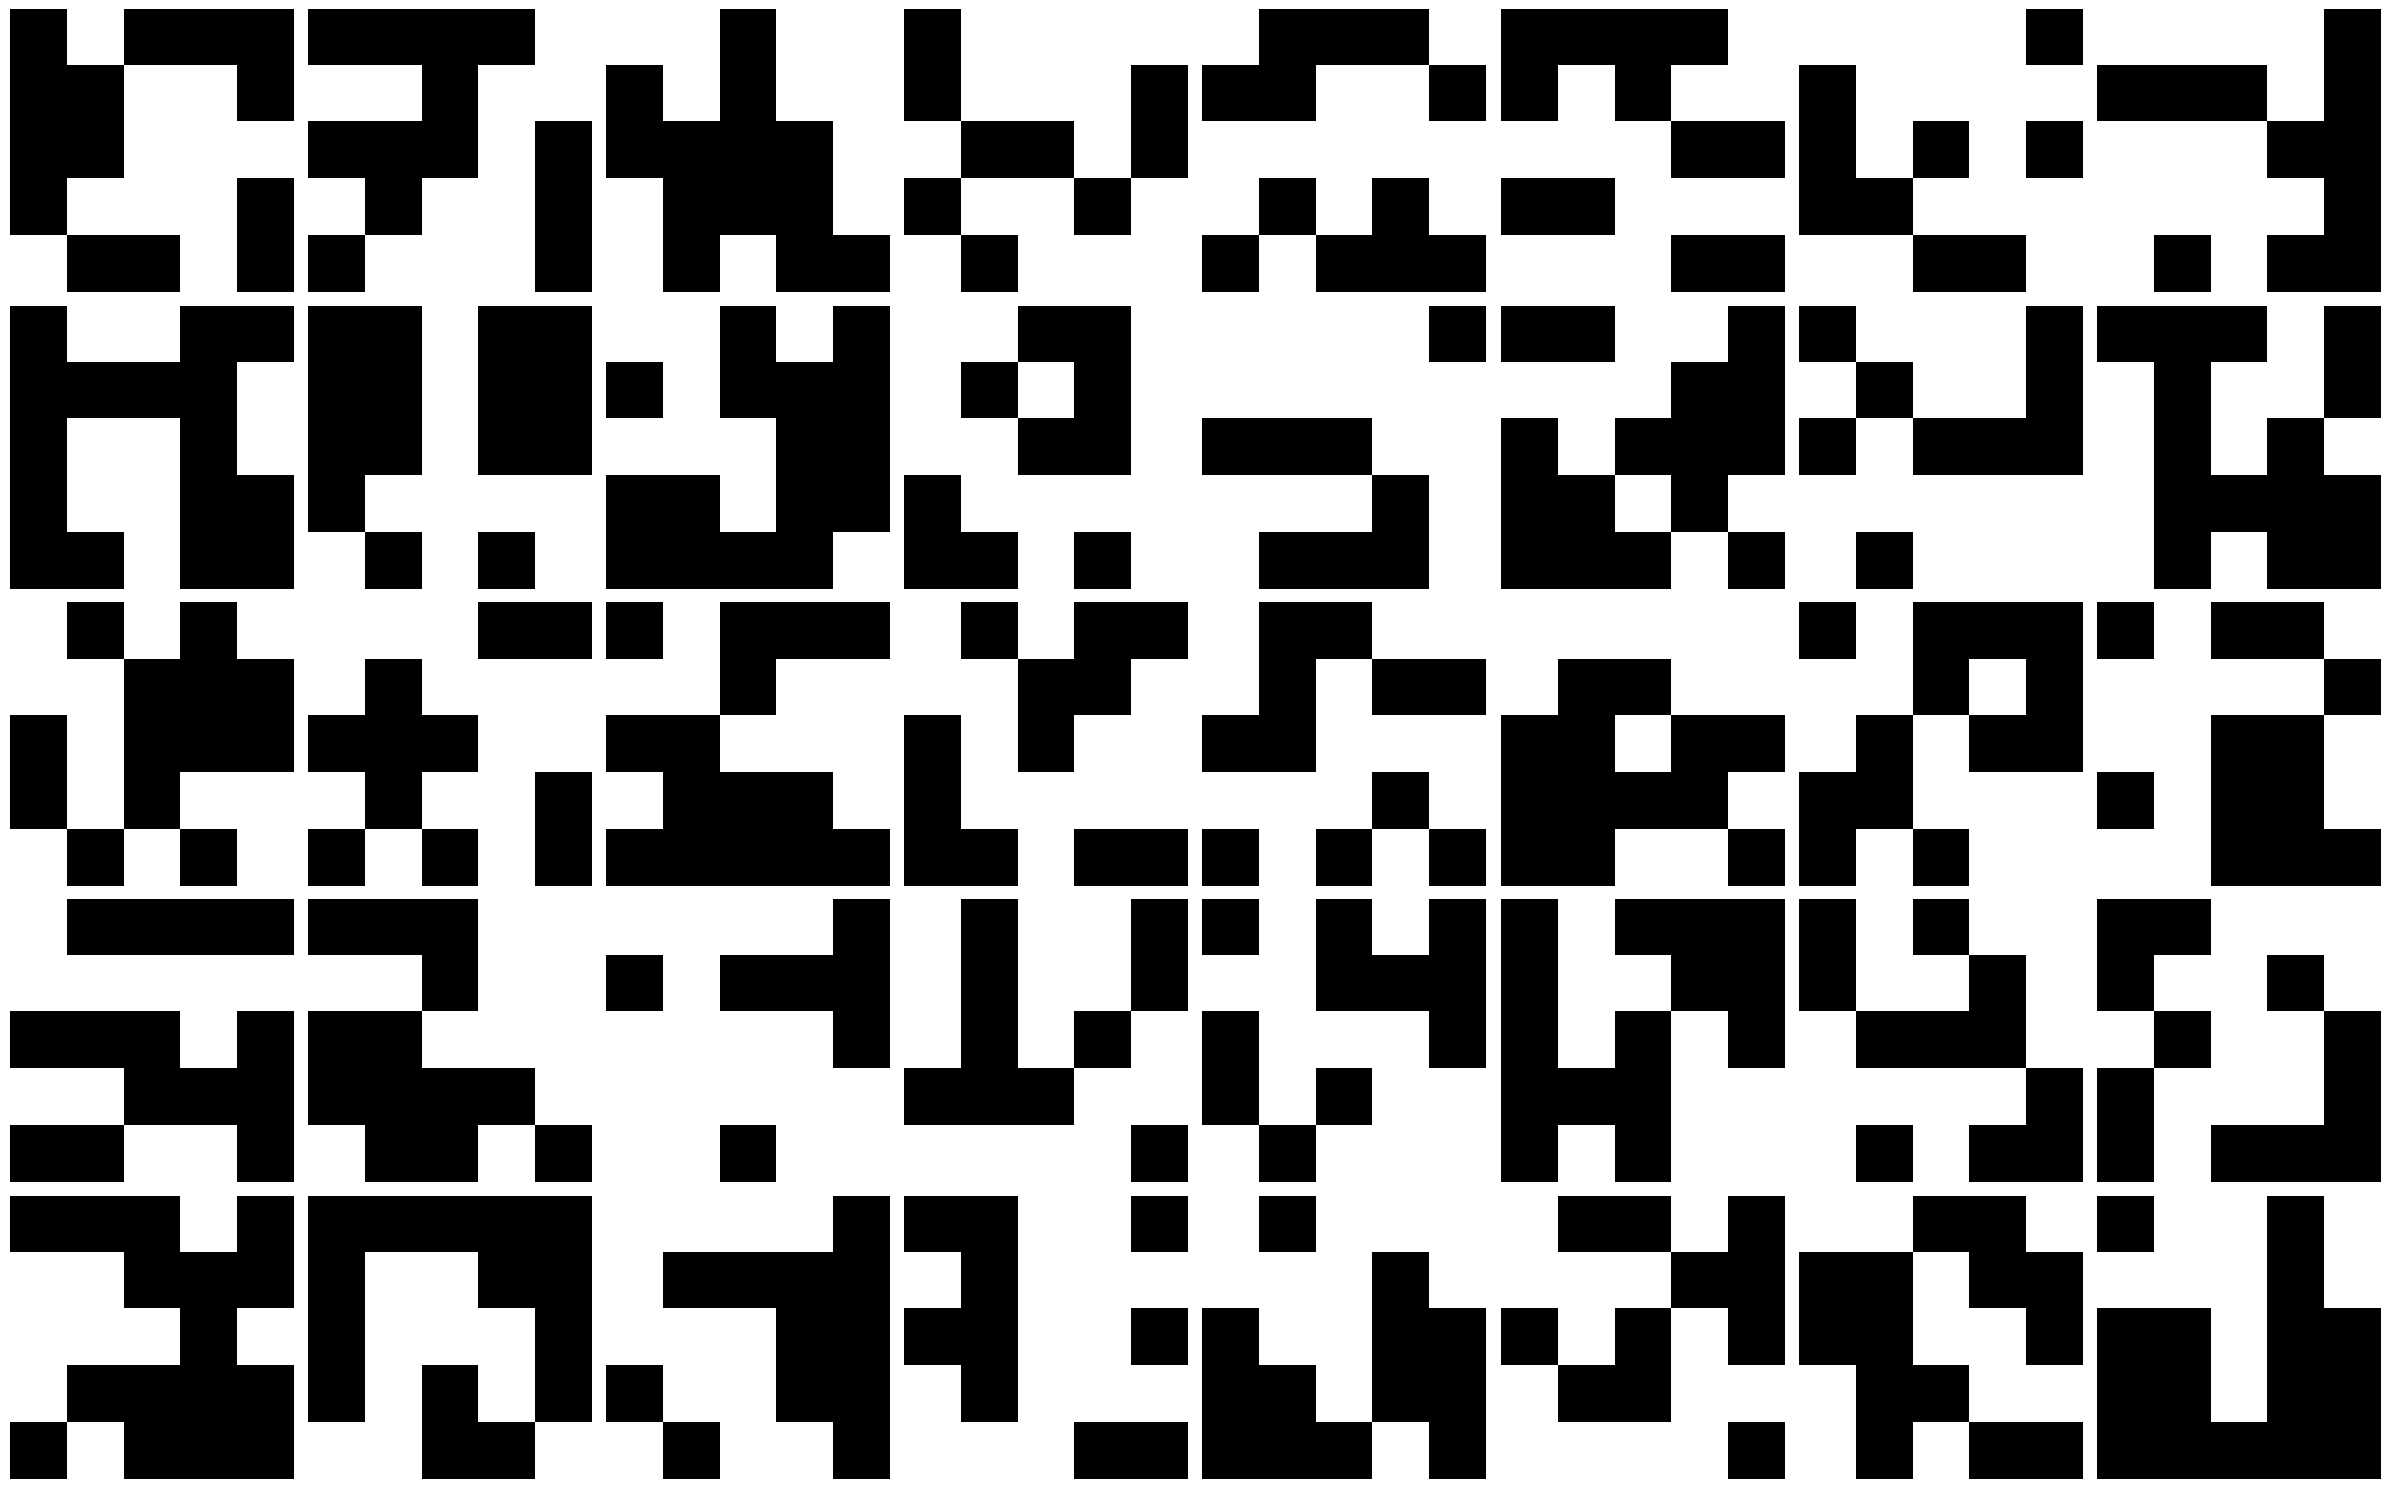

In [14]:
fig, axes = plt.subplots(5, 8, figsize=(24, 15))

# plot images on a 5x8 grid
for idx, ax in enumerate(axes.flat):
    ax.imshow(images[idx], cmap='binary')
    ax.axis('off')  # no axes
plt.tight_layout()
plt.show()

# Algorithm Motivation

Using the underlying retrieval and update rules of the Hopfield network, we'd like to create an algorithm for short-term memory for our visual task.

In each iteration of the task, a player has one of two choices, to declare a stimulus as **seen** or **new**, which can be interpreted as a choice of whether or not to **store a new pattern**. But how do we make this decision?

## Hamming Distance
We can do so by calculating the Hamming difference between the recalled pattern and the input pattern, and using this difference as a metric depending on how close it is to either 0 or 25. To account for the stochasticity of human nature, we use the Hamming distance as a probabilistic metric. This makes sense, since if the returned image is the same as our input, it's very likely that our input already belongs in the prototype set. Essentially, if the Hamming distance between the input and the recalled pattern is 1, there is an $e^{-1} \approx 0.36$ chance that this image has already been seen. It's likely that this is more than 0.36, so we'll need some kind of scaling factor to account for this.

## Scaling
As the number of stored prototypes of a Hopfield network increases beyond the capacity of the network, the likelihood of the network converging to a prototype state begins to decrease significantly. We therefore must tune our sensitivity to the Hamming distance *by the likelihood of hallucinating a spurious state.* This spurious scaling factor, $s$, can be formulated as a temperature for our softmax.

Thus,

$$P(\text{input }I \text{ input is seen}) = \exp(-C\cdot \text{hamming}(I, \zeta)\cdot s(l))$$

for some constant of proportionality C. For our ease, we'll set C as 1 for now.

Altogether, our short-term recall algorithm looks something like this:


```
for idx, input in enumerate(inputs):
  result = hop.recall(input)
  l = len(hop.prototypes)
  hamming = hamming(result, input) #0 if hamming is 0 or 25
  p_seen = exp(- hamming * spurious(l)) #flip with this probability
  seen = flip(p_seen)
  if seen:
    # don't do anything
    continue
  else:
    # store a new pattern, and update weights
    self.prototypes.append(input)
    self.weights += np.outer(input, input) / self.nodes

```



# Scaling factor

To calculate an approximate scaling function, we empirically determine the relationship between the **probability of returning a spurious output** and the **number of stored patterns.**

We know that below capacity $N/2\log_2(N)$, a Hopfield network should be able to theoretically perform perfect retrieval from its prototype set. For $N = 25$, this is approximately ~2.7, but using the more generous $0.14N$ approximation gives us 3.5.


We will set up Hopfield network with different number of prototypes, test its non-spurious retrieval rates on 50 randomly generated inputs, and graph the results:

In [47]:
prototype_superset = np.random.choice([-1, 1], size=(50, 25)) # up to 50 prototypes
seeds = np.random.choice([1, -1], size=(1000, 25))

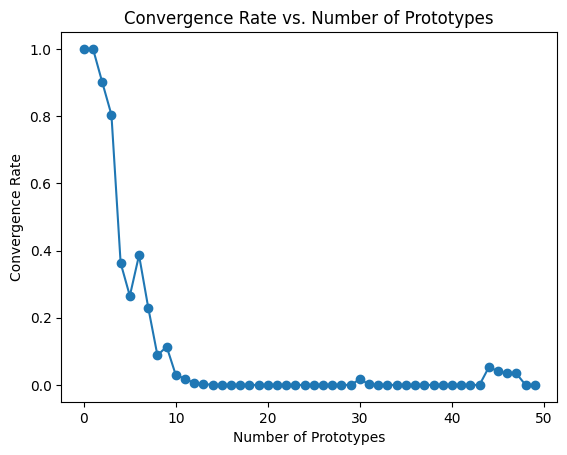

In [154]:
accuracy = []
for i in range(50):
  network = Hopfield(25, 100)
  network.fill_prototypes(prototype_superset[:i+1])
  pred = [network.recall(s)[0] for s in seeds] # predictions
  convergence = [p for p in pred if check_convergence(p, network.prototypes)[0] == 0 or check_convergence(p, network.prototypes)[0] == 25]
  accuracy.append(len(convergence) / len(pred))

plt.plot(range(50), accuracy)
plt.scatter(range(50), accuracy)
plt.title("Convergence Rate vs. Number of Prototypes")
plt.xlabel("Number of Prototypes")
plt.ylabel("Convergence Rate")
plt.show()

As predicted, the convergence rate sharply falls after the number of protypes increases past N=3. We'll therefore draw from `accuracy` to get our value of $s(l)$. Additionally, as the convergence rate goes to zero for many entries, we will impose a minimum $s(l) \geq 0.01$.


# Hopfield with Short Term Recall

We're now ready to construct the short-term recall algorithm:

In [168]:
class HopfieldShortTerm(Hopfield):
  def __init__(self, num_nodes, max_iter):
    super().__init__(num_nodes, max_iter)

  def short_term_recall(self, inputs, c=1):
    seen_list = []
    for idx, input in enumerate(inputs):
      if idx == 0:
        self.fill_prototypes([input])
        seen_list.append(0)
        continue
      else:
        result, _ = self.recall(input)
        l = len(self.prototypes)
        h = hamming(result, input) #0 if hamming is 0 or 25
        p_seen = np.exp(- c*h * max(accuracy[l-1], 0.01)) #flip with this probability
        seen = np.random.choice([0, 1], p=[1-p_seen, p_seen])
        seen_list.append(seen)
        if not seen:
          self.prototypes = np.append(self.prototypes, [input], axis=0)
          # update weights and zero out diagonal
          self.weights += np.outer(input, input) / self.num_nodes
          np.fill_diagonal(self.weights, 0)
    return seen_list

# Implementation

We now run our model on our experiment.

In [141]:
short_term_network = HopfieldShortTerm(25, 100)

In [110]:
# generate a list of 30 samples from images, with replacement
sample_idxs = np.random.randint(0, 40, 30)
samples = [images[i].flatten() for i in sample_idxs]

# answer key
seen_truth = [1 if sample_idxs[i] in set(sample_idxs[:i]) else 0 for i in range(30) ]
print(sample_idxs)
print(seen_truth)

[10 38  9 37  6 10 21 11  8 23 33  8 19  6 39 32 34  7 34 35 25  1 21 33
 37 34  7 22 10  7]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]


In [142]:
seen_array = short_term_network.short_term_recall(samples)

7.0 1.0
0.0009118819655545162
5.5 1.0
0.004086771438464067
7.5 0.888
0.0012811463703842113
8.0 0.811
0.0015215891452077799
4.5 0.37
0.18919065798198204
6.0 0.37
0.10860910882495801
7.5 0.278
0.12430712016577938
4.5 0.372
0.18749558134675456
6.5 0.229
0.225710968193805
5.0 0.1
0.6065306597126334
4.5 0.099
0.6405039439839882
6.5 0.036
0.7913618158955839
8.0 0.018
0.865887748059205
4.5 0.018
0.922193691444608
4.5 0.018
0.922193691444608
6.5 0.006
0.9370674633774034
7.0 0.006
0.9323938199059483
6.5 0.006
0.9370674633774034
7.5 0.006
0.9277434863285529
6.0 0.006
0.9417645335842487
6.0 0.006
0.9417645335842487
6.0 0.006
0.9417645335842487
5.0 0.006
0.951229424500714
7.0 0.006
0.9323938199059483
6.5 0.006
0.9370674633774034
7.0 0.003
0.9323938199059483
6.0 0.003
0.9417645335842487
4.5 0.003
0.9559974818331
7.0 0.003
0.9323938199059483


Accuracy: 70.0%


Text(0, 0.5, 'Accuracy')

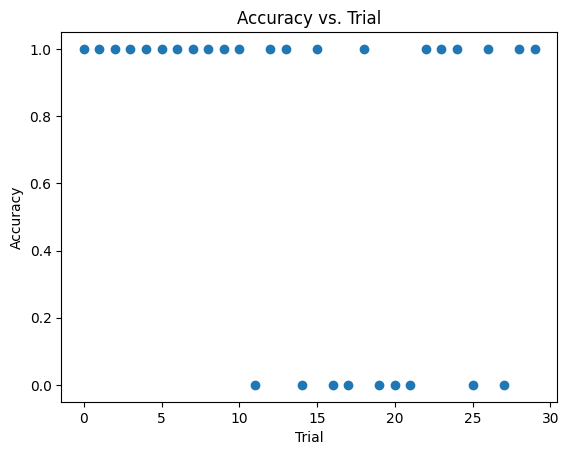

In [157]:
task_accuracy = 1- abs(np.array(seen_truth) - np.array(seen_array))
print(f"Accuracy: {100*sum(task_accuracy)/30}%")
plt.scatter(range(30), task_accuracy)
plt.title("Accuracy vs. Trial")
plt.xlabel("Trial")
plt.ylabel("Accuracy")

# Comparison to Human Data

We collected feedback from 7 individuals performing this cognitive task. The average accuracy of these 7 individuals was $22.8/30 = 0.76$, which is reasonably close to the accuracy that we found.

Simulating our model over multiple iterations,

In [163]:
human_accuracies = [22/30, 21/30, 23/30, 23/30, 22/30, 25/30, 24/30]

In [169]:
def acc(iters, c=1):
  fin = []
  for j in range(iters):
    sample_idxs = np.random.randint(0, 40, 30)
    samples = [images[i].flatten() for i in sample_idxs]

    # answer key
    seen_truth = [1 if sample_idxs[i] in set(sample_idxs[:i]) else 0 for i in range(30)]

    # network and training
    stn = HopfieldShortTerm(25, 100)
    seen_array = stn.short_term_recall(samples, c)
    a = np.sum(1- abs(np.array(seen_truth) - np.array(seen_array)))/30
    fin.append(a)
    print(f"Accuracy for iter {j}: {100*a}%")

  return fin

# plot average of accuracies
accuracies_over_iterations = acc(7)

Accuracy for iter 0: 63.33333333333333%
Accuracy for iter 1: 56.666666666666664%
Accuracy for iter 2: 56.666666666666664%
Accuracy for iter 3: 66.66666666666666%
Accuracy for iter 4: 53.333333333333336%
Accuracy for iter 5: 56.666666666666664%
Accuracy for iter 6: 60.0%


We compare the accuracies of human subjects to our model, for different values of $C$.

Accuracy for iter 0: 50.0%
Accuracy for iter 1: 43.333333333333336%
Accuracy for iter 2: 43.333333333333336%
Accuracy for iter 3: 36.666666666666664%
Accuracy for iter 4: 53.333333333333336%
Accuracy for iter 5: 50.0%
Accuracy for iter 6: 46.666666666666664%
Accuracy for iter 0: 50.0%
Accuracy for iter 1: 70.0%
Accuracy for iter 2: 66.66666666666666%
Accuracy for iter 3: 53.333333333333336%
Accuracy for iter 4: 66.66666666666666%
Accuracy for iter 5: 53.333333333333336%
Accuracy for iter 6: 60.0%
Accuracy for iter 0: 73.33333333333333%
Accuracy for iter 1: 60.0%
Accuracy for iter 2: 70.0%
Accuracy for iter 3: 63.33333333333333%
Accuracy for iter 4: 66.66666666666666%
Accuracy for iter 5: 80.0%
Accuracy for iter 6: 70.0%
Accuracy for iter 0: 46.666666666666664%
Accuracy for iter 1: 56.666666666666664%
Accuracy for iter 2: 66.66666666666666%
Accuracy for iter 3: 50.0%
Accuracy for iter 4: 66.66666666666666%
Accuracy for iter 5: 73.33333333333333%
Accuracy for iter 6: 66.66666666666666%


<ipython-input-187-8276a0179a2e>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_accuracies, labels=labels)


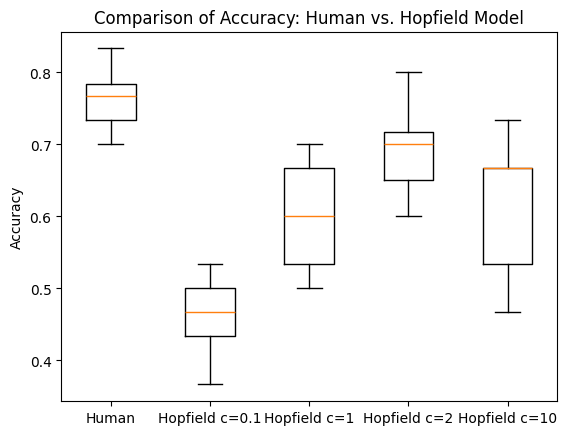

In [187]:
c_values = [0.1, 1, 2, 10]
all_accuracies = [human_accuracies]
labels = ['Human']

for idx, c in enumerate(c_values):
  label = f'Hopfield c={c}'
  all_accuracies.append(acc(7, c))
  labels.append(label)

plt.boxplot(all_accuracies, labels=labels)
plt.title("Comparison of Accuracy: Human vs. Hopfield Model")
plt.ylabel("Accuracy")
plt.show()

# Remarks

Our Hopfield model still has a ways to go, but it is currently able to approximately replicate the human accuracy rate in short-term memory games fairly well.

There is a famously quoted study from the 1956 Psychological Review which quotes that humans can hold around 7 bits of short term memory, which is far more than the 3 patterns that our network permits. Our Hopfield model has $N=25$ neurons for compatibiltiy with the input image, but it's likely that humans use more than 25 neurons to represent these inputs. This difference may be a main reason why we see human performance greatly outclass our Hopfield algorithm.

Additionally, it did not appear that differing values of $C$ were able to better capture the mean of the distribution, although it appears that $C=1$ and $C=2$ capture the size of the distribution well. We used a simple rule for incorporating the how the likelihood of spurious patterns affect the ability to classify a pattern as already seen, which may not be well biologically motivated.

However, the success of this short-term memory retrieval algorithm on Hopfield networks gives exciting hope that the functions of different types of memory may be connected to similar underlying mechanisms. I'd love to see some future work with architectures that are better biologically motivated in line with our understanding of how neurons for short-term are actually interoperating!